In [2]:
import re

import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
alexa_df = pd.read_csv('../data/raw/amazon-alexa.tsv', delimiter='\t')
alexa_df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [4]:
alexa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


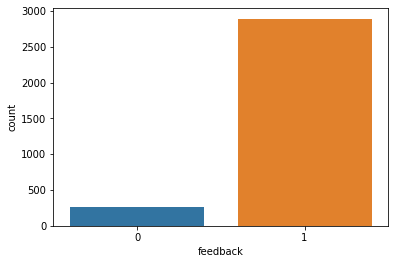

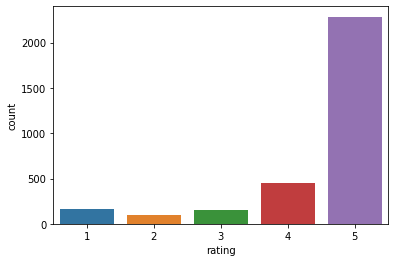

In [5]:
alexa_df_positive = alexa_df[alexa_df['feedback'] == 1]
alexa_df_negative = alexa_df[alexa_df['feedback'] == 0]

sns.countplot(x=alexa_df['feedback'], label='count')
plt.show()

sns.countplot(x=alexa_df['rating'], label='count')
plt.show()

In [6]:
alexa_variation_onehot = pd.get_dummies(alexa_df['variation'])
alexa_rating_onehot = pd.get_dummies(alexa_df['rating'])
alexa_rating_onehot.columns = ['1 Star', '2 Stars', '3 Stars', '4 Stars',
                               '5 Stars']

alexa_onehot = pd.concat((alexa_variation_onehot, alexa_rating_onehot), axis=1)
alexa_onehot

,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,White,White Dot,White Plus,White Show,White Spot,1 Star,2 Stars,3 Stars,4 Stars,5 Stars
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3146,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3147,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3148,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [7]:
alexa_df.drop(['rating', 'date', 'variation'], axis=1, inplace=True)
alexa_df = pd.concat((alexa_onehot, alexa_df), axis=1)
alexa_df

,Black,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,...,White Plus,White Show,White Spot,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,verified_reviews,feedback
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,Love my Echo!,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,Loved it!,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,"Sometimes while playing a game, you can answer...",1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,I have had a lot of fun with this thing. My 4 ...,1
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,Music,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"Perfect for kids, adults and everyone in betwe...",1
3146,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"Listening to music, searching locations, check...",1
3147,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"I do love these things, i have them running my...",1
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,Only complaint I have is that the sound qualit...,1


In [8]:
# Delete reviews with 2 or less characters as stop words.
alexa_df['verified_reviews'] = [re.sub(r'\b\w{1,2}\b', '', review) 
                                for review
                                in alexa_df['verified_reviews']]

nltk.download('stopwords')
en_stopwords = nltk.corpus.stopwords.words('english')

vectorizer = CountVectorizer(stop_words=en_stopwords)
reviews_tokens = vectorizer.fit_transform(alexa_df['verified_reviews'])
print(reviews_tokens.shape)

(3150, 3800)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
alexa_df.drop('verified_reviews', axis=1, inplace=True)

reviews = pd.DataFrame(reviews_tokens.toarray(),
                       columns=vectorizer.get_feature_names_out())

# Remove columns that come from numerical or very short texts.
stop_word_columns = [word
                     for word
                     in reviews.columns
                     if len(word) < 3
                     or re.match(r'^[0-9]+$', word)]
reviews.drop(stop_word_columns, axis=1, inplace=True)

alexa_df = pd.concat((reviews, alexa_df), axis=1)
alexa_df

,100x,1100sf,12am,1gb,1rst,1st,2nd,2package,30pm,3rd,...,White Dot,White Plus,White Show,White Spot,1 Star,2 Stars,3 Stars,4 Stars,5 Stars,feedback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3148,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1


In [10]:
X = alexa_df.iloc[:, :-1].values
y = alexa_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

In [ ]:
nlp_nn_model = tf.keras.models.Sequential()
nlp_nn_model.add(tf.keras.layers.Dense(units=50, activation='relu',
                                       input_shape=(X_train.shape[1],)))
nlp_nn_model.add(tf.keras.layers.Dense(units=25, activation='relu'))
nlp_nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nlp_nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                190300    
                                                                 
 dense_13 (Dense)            (None, 25)                1275      
                                                                 
 dense_14 (Dense)            (None, 1)                 26        
                                                                 
Total params: 191,601
Trainable params: 191,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5
)
batch_size = X_train.shape[0] // 20

nlp_nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                     loss='binary_crossentropy', metrics=['accuracy'])

epochs_info = nlp_nn_model.fit(X_train,
                               y_train,
                               batch_size=batch_size,
                               epochs=100,
                               validation_split=0.15,
                               callbacks=[early_stopping_callback])

Epoch 1/100
18/18 [==============================] - 1s 16ms/step - loss: 0.5715 - accuracy: 0.9002 - val_loss: 0.4026 - val_accuracy: 0.9527
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 0.3358 - accuracy: 0.9156 - val_loss: 0.2275 - val_accuracy: 0.9527
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1930 - accuracy: 0.9169 - val_loss: 0.1367 - val_accuracy: 0.9552
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 0.1105 - accuracy: 0.9407 - val_loss: 0.0927 - val_accuracy: 0.9652
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0701 - accuracy: 0.9802 - val_loss: 0.0709 - val_accuracy: 0.9751
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0444 - accuracy: 0.9978 - val_loss: 0.0596 - val_accuracy: 0.9826
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.0540 - val_accuracy: 0.9801
Epoch 8/10

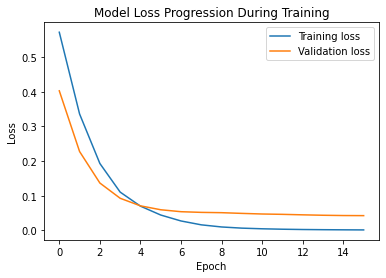

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

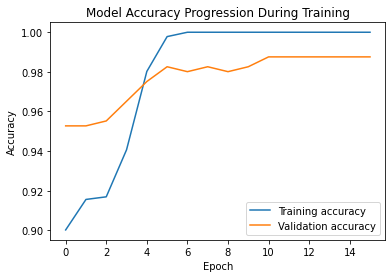

In [ ]:
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

In [ ]:
y_pred = nlp_nn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred_classes)
print("Model prediction confusion matrix:")
print(cm)

15/15 [==============================] - 0s 3ms/step
Model prediction confusion matrix:
[[ 42   4]
 [  0 427]]


In [11]:
X = alexa_df.iloc[:, :-6].values
y = alexa_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42)

In [47]:
nlp_nn_model_no_rating = tf.keras.models.Sequential()
nlp_nn_model_no_rating.add(tf.keras.layers.Dense(units=20, activation='relu',
                                       input_shape=(X_train.shape[1],)))
nlp_nn_model_no_rating.add(tf.keras.layers.Dense(units=10, activation='relu'))
nlp_nn_model_no_rating.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

nlp_nn_model_no_rating.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 20)                76020     
                                                                 
 dense_20 (Dense)            (None, 10)                210       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 76,241
Trainable params: 76,241
Non-trainable params: 0
_________________________________________________________________


In [48]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5
)
batch_size = X_train.shape[0] // 20

nlp_nn_model_no_rating.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', metrics=['accuracy']
)

epochs_info = nlp_nn_model_no_rating.fit(X_train,
                                         y_train,
                                         batch_size=batch_size,
                                         epochs=100,
                                         validation_split=0.15,
                                         callbacks=[early_stopping_callback])

Epoch 1/100
18/18 [==============================] - 1s 33ms/step - loss: 0.6505 - accuracy: 0.8382 - val_loss: 0.5723 - val_accuracy: 0.9527
Epoch 2/100
18/18 [==============================] - 0s 21ms/step - loss: 0.5168 - accuracy: 0.9156 - val_loss: 0.4273 - val_accuracy: 0.9527
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 0.4007 - accuracy: 0.9156 - val_loss: 0.3343 - val_accuracy: 0.9527
Epoch 4/100
18/18 [==============================] - 0s 19ms/step - loss: 0.3210 - accuracy: 0.9156 - val_loss: 0.2749 - val_accuracy: 0.9527
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 0.2608 - accuracy: 0.9174 - val_loss: 0.2321 - val_accuracy: 0.9527
Epoch 6/100
18/18 [==============================] - 0s 21ms/step - loss: 0.2130 - accuracy: 0.9284 - val_loss: 0.1983 - val_accuracy: 0.9577
Epoch 7/100
18/18 [==============================] - 0s 28ms/step - loss: 0.1740 - accuracy: 0.9442 - val_loss: 0.1727 - val_accuracy: 0.9577
Epoch 

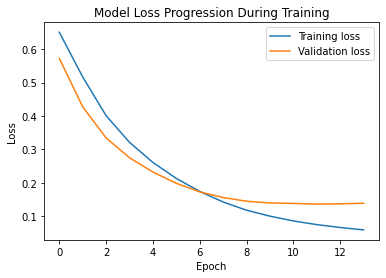

In [49]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

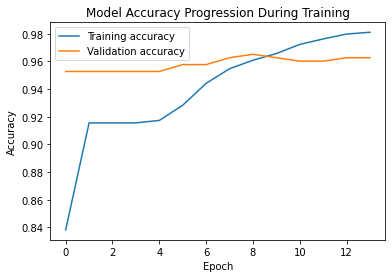

In [50]:
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()

In [51]:
y_pred = nlp_nn_model_no_rating.predict(X_test)
y_pred_classes = (y_pred > 0.5)

cm = confusion_matrix(y_test, y_pred_classes)
print("Model prediction confusion matrix:")
print(cm)

15/15 [==============================] - 0s 3ms/step
Model prediction confusion matrix:
[[ 15  31]
 [  1 426]]
